<a href="https://colab.research.google.com/github/Lukec-lehighu/CSE337-Labs/blob/main/lab6_nonlinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6: Non-linear function approximation

## Exercise 1: Q-Learning with a Neural Network (PyTorch) on MountainCar

**Objective:**
Implement **Q-learning** with a **PyTorch neural network** to solve `MountainCar-v0`. You will approximate Q(s, a) with a small MLP, train it from batches of transitions sampled from a replay buffer, and evaluate the learned policy.

---

## Environment
- **Gym** environment: `MountainCar-v0`
- **State**: continuous (position, velocity) → shape `(2,)`
- **Actions**: {0: left, 1: no push, 2: right}
- **Reward**: -1 per step until the goal (`position >= 0.5`)
- **Episode limit**: 500 steps
- **Goal**: reduce steps-to-goal and improve return over training

---

## What You Must Implement

### 1) Q-Network (PyTorch)
Create a small MLP `QNetwork` that maps `state -> Q-values for 3 actions`.
- Inputs: `(batch_size, 2)` float32
- Outputs: `(batch_size, 3)` Q-values
- Suggested architecture: `2 → 64 → 3` with ReLU
- Initialize weights reasonably (PyTorch defaults are fine)

### 2) Replay Buffer
A cyclic buffer to store transitions `(s, a, r, s_next, done)`:
- `append(s, a, r, s_next, done)`
- `sample(batch_size)` → tensors ready for PyTorch (float32 for states, int64 for actions, float32 for rewards/done)

### 3) ε-Greedy Policy
- With probability `epsilon`: pick a random action
- Otherwise: `argmax_a Q(s, a)` from the current network
- Use **decaying ε** (e.g., from 1.0 down to 0.05 over ~20–50k steps)

### 4) Q-Learning Target and Loss
For a sampled batch:
- Compute `q_pred = Q(s).gather(1, a)`  (shape `(batch, 1)`)
- Compute target:
  - If `done`: `target = r`
  - Else: `target = r + gamma * max_a' Q(s_next, a').detach()`
- Loss: Mean Squared Error (MSE) between `q_pred` and `target`

> **Stabilization (recommended)**: Use a **target network** `Q_target` (periodically copy weights from `Q_online`) to compute the max over next-state actions. Update every `target_update_freq` steps.

### 5) Deep Q-learning method
- For each environment step:
  1. Select action with ε-greedy
  2. Step the env, store transition in buffer
  3. If `len(buffer) >= batch_size`:
     - Sample a batch
     - Compute `q_pred`, `target`
     - Backprop: `optimizer.zero_grad(); loss.backward(); optimizer.step()`
     - (Optional) gradient clipping (e.g., `clip_grad_norm_` at 10)
  4. Periodically update `Q_target ← Q_online` (if using target net)
- Track episode returns (sum of rewards) and steps-to-goal

---

## Evaluation
- Run **evaluation episodes** with `epsilon = 0.0` (greedy) every N training episodes
- Report:
  - Average steps-to-goal (lower is better; random policy is ~200)
  - Average return (less negative is better)
- Plot:
  - Training episode return

---

## Deliverables
1. **Code**: In a notebook.
2. **Plots**:
   - Episode  vs return
   - Final value function (State (postition and velocity) Vs Max(Q(state)))

3. **Short write-up** (also in the notebook):
   - **Performance of your DQN agent**: How quickly does it learn? Does it reach the goal consistently?
   - **Comparison with tile coding**:
     - Which representation learns faster?
     - Which one is more stable?
     - How do the function approximation choices (linear with tiles vs. neural network) affect generalization?
     - Did the NN require more tuning (learning rate, ε schedule) compared to tile coding?
   - **Insights**: What are the trade-offs between hand-crafted features (tiles) and learned features (neural networks)?



In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# Set up environment
env = gym.make("MountainCar-v0")
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

# Hyperparameters
gamma = 0.99
alpha = 0.001
epsilon = 0.1
num_episodes = 200
batch_size = 64
replay_buffer_size = 50000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
# Initialize Q-network and optimizer
q_net = QNetwork(state_dim, n_actions).to(device)
optimizer = optim.Adam(q_net.parameters(), lr=alpha)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=replay_buffer_size)

In [ ]:
def epsilon_greedy(state, epsilon):
  if np.random.rand() < epsilon:
    return np.random.randint(n_actions)

  state_tensor = torch.FloatTensor(state).to(device).unsqueeze(0)
  with torch.no_grad():
    q_values = q_net(state_tensor)
    return int(np.argmax(q_values))

In [ ]:
def train_dqn():
    """Train the DQN using experience replay."""
    if len(replay_buffer) < batch_size:
        return
    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(np.array(states)).to(device)
    actions = torch.LongTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(np.array(next_states)).to(device)
    dones = torch.FloatTensor(dones).to(device)

    q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = q_net(next_states).max(1)[0].detach()
    targets = rewards + gamma * next_q_values * (1 - dones)

    loss = loss_fn(q_values, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
## MAIN Loop ###
rewards_dqn = []

for episode in range(num_episodes):
  state = env.reset()[0]
  total_reward = 0
  done = False

  while not done:
    action = epsilon_greedy(state, epsilon)
    next_state, reward, done, _, _ = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done))
    train_dqn()
    state = next_state
    total_reward += reward

  rewards_dqn.append(total_reward)
  print(f'Episode {episode+1}: {total_reward}')

Episode 1: -7403.0
Episode 2: -1689.0
Episode 3: -2534.0
Episode 4: -3124.0
Episode 5: -4479.0
Episode 6: -847.0
Episode 7: -670.0
Episode 8: -431.0
Episode 9: -235.0
Episode 10: -163.0
Episode 11: -141.0
Episode 12: -151.0
Episode 13: -109.0
Episode 14: -99.0
Episode 15: -159.0
Episode 16: -171.0
Episode 17: -166.0
Episode 18: -158.0
Episode 19: -171.0
Episode 20: -157.0
Episode 21: -141.0
Episode 22: -167.0
Episode 23: -187.0
Episode 24: -161.0
Episode 25: -592.0
Episode 26: -226.0
Episode 27: -136.0
Episode 28: -157.0
Episode 29: -187.0
Episode 30: -322.0
Episode 31: -153.0
Episode 32: -166.0
Episode 33: -147.0
Episode 34: -161.0
Episode 35: -155.0
Episode 36: -89.0
Episode 37: -158.0
Episode 38: -157.0
Episode 39: -170.0
Episode 40: -140.0
Episode 41: -125.0
Episode 42: -168.0
Episode 43: -169.0
Episode 44: -140.0
Episode 45: -149.0
Episode 46: -174.0
Episode 47: -152.0
Episode 48: -128.0
Episode 49: -100.0
Episode 50: -115.0
Episode 51: -176.0
Episode 52: -88.0
Episode 53: -97.0
E

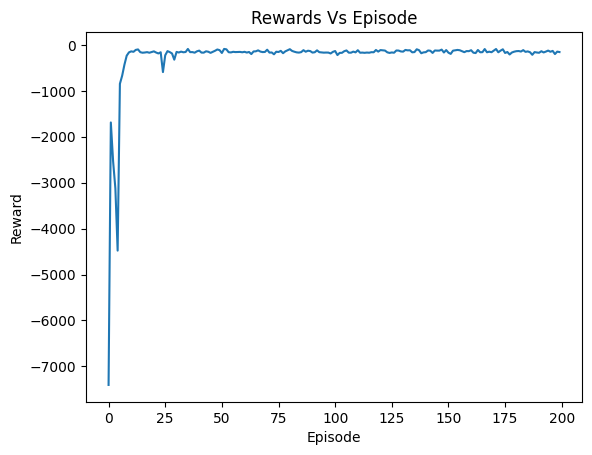

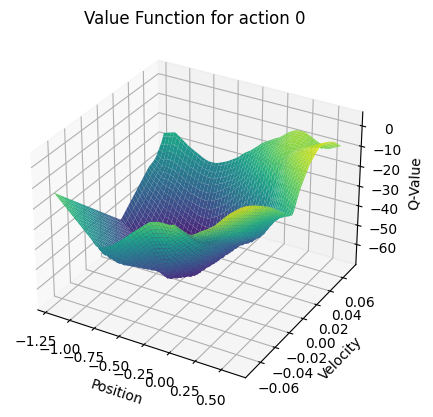

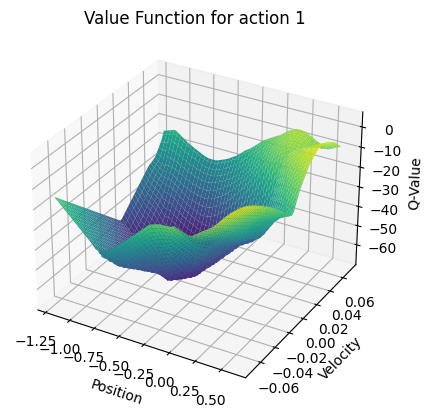

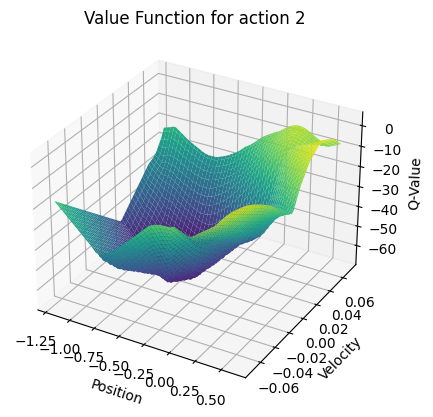

In [ ]:
#rewards vs episode
plt.plot(rewards_dqn)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards Vs Episode')
plt.show()

#value function
def get_output(state):
  state_tensor = torch.FloatTensor(state).to(device).unsqueeze(0)
  with torch.no_grad():
    q_values = q_net(state_tensor)
    return q_values

position_range = np.linspace(-1.2, 0.6, 100)
velocity_range = np.linspace(-0.07, 0.07, 100)

X, Y = np.meshgrid(position_range, velocity_range)

for action in range(3):
  Z = np.array([float(get_output((x,y))[0][action])
                for x, y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

  # Create a 3D plot
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  # Plot the surface
  ax.plot_surface(X, Y, Z, cmap='viridis')

  # Set labels and title
  ax.set_title(f'Value Function for action {action}')
  ax.set_xlabel('Position')
  ax.set_ylabel('Velocity')
  ax.set_zlabel('Q-Value')
  plt.show()

**How quickly does the agent learn? Does it reach the goal consistently?**
 - The agent takes around 10 episodes to learn and reaches the goal fairly consistently.

**Comparison with tile coding:**
 - Which representation learns faster?
    - The DNN learned faster than the tile coding.
 - Which one is more stable?
    - The DNN algorithm has less spikes in loss than the tile method.
 - How do the function approximation choices (linear with tiles vs. neural network) affect generalization?
    - The neural network was able to generalize better than the tile method. The graphs of the states vs output of the tile method has values outside of the training data equal to 0, while the output for the neural net is varied outside of the training data, suggesting that the model generalized to handle never-before-seen input data.
 - Did the NN require more tuning (learning rate, ε schedule) compared to tile coding?
    - The NN has more parameters to change, but was able to learn with similar amounts of tuning as with tile coding.
 - Insights: What are the trade-offs between hand-crafted features (tiles) and learned features (neural networks)?
    - Learned features requires less setup and knowledge of the environment as hand-crafted features, however neural networks might not always be the most computationally efficient solution since they need to spend time learning the environment on their own.

# Exercise 2: Deep Q-Learning (DQN) on LunarLander-v2

## Problem Description
In this exercise, you will implement **Deep Q-Learning (DQN)** to solve the classic control problem **LunarLander-v2** in Gym.

### The Task
The agent controls a lander that starts at the top of the screen and must safely land on the landing pad between two flags.

- **State space**: Continuous vector of 8 variables, including:
  - Position (x, y)
  - Velocity (x_dot, y_dot)
  - Angle and angular velocity
  - Left/right leg contact indicators
- **Action space**: Discrete, 4 actions
  - 0: do nothing
  - 1: fire left orientation engine
  - 2: fire main engine
  - 3: fire right orientation engine
- **Rewards**:
  - +100 to +140 for successful landing
  - -100 for crashing
  - Small negative reward for firing engines (fuel cost)
  - Episode ends when lander crashes or comes to rest

The goal is to train an agent that lands successfully **most of the time**.

---

## Algorithm: Deep Q-Learning
You will implement a **DQN agent** with the following components:

1. **Q-Network**
   - Neural network that approximates Q(s, a).
   - Input: state vector (8 floats).
   - Output: Q-values for 4 actions.
   - Suggested architecture: 2 hidden layers with 128 neurons each, ReLU activation.

2. **Target Network**
   - A copy of the Q-network that is updated less frequently (e.g., every 1000 steps).
   - Used for stable target computation.

3. **Replay Buffer**
   - Stores transitions `(s, a, r, s_next, done)`.
   - Sample random mini-batches to break correlation between consecutive samples.

4. **ε-Greedy Policy**
   - With probability ε, take a random action.
   - Otherwise, take `argmax_a Q(s, a)`.
   - Decay ε over time (e.g., from 1.0 → 0.05).

5. **Q-Learning Method**
   


**Final note:**
   No code base is necessary. At this point, you must know how to implement evertything.
   For reference, but not recommended ([Here](https://colab.research.google.com/drive/1Gl0kuln79A__hgf2a-_-mwoGISXQDK_X?authuser=1#scrollTo=8Sd0q9DG8Rt8&line=56&uniqifier=1) is a solution)

---
## Deliverables
1. **Code**:
- Q-network (PyTorch).
- Training loop with ε-greedy policy, target network, and Adam optimizer.

2. **Plots**:
- Episode returns vs training episodes.
- Evaluation performance with a greedy policy (ε = 0).

3. **Short Write-up (≤1 page)**:
- Did your agent learn to land consistently?  
- How many episodes did it take before you saw improvement?  
- What effect did replay buffer size, target update frequency, and learning rate have on stability?  
- Compare results across different runs (does it sometimes fail to converge?).

Compare this task with the **MountainCar-v0** problem you solved earlier:
- What is **extra** or more challenging in LunarLander?  
- Consider state dimensionality, number of actions, reward shaping, and the difficulty of exploration.  
- Why might DQN be necessary here, whereas simpler methods (like tile coding) could work for MountainCar?


In [ ]:
!pip install swig
!pip install "gymnasium[box2d]"

   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 2.6/2.6 MB 16.5 MB/s  0:00:00


^C


In [ ]:
# Set up environment
env = gym.make("LunarLander-v3", render_mode='human')
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

In [ ]:
# Initialize Q-network and optimizer
q_net = QNetwork(state_dim, n_actions).to(device)
optimizer = optim.Adam(q_net.parameters(), lr=alpha)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=replay_buffer_size)

In [ ]:
## MAIN Loop ###
num_episodes = 400
rewards_dqn = []
MAX_STEPS = 2000

for episode in range(num_episodes):
  if episode % 20 == 0:
    env = gym.make("LunarLander-v3", render_mode='human')
  else:
    env = gym.make("LunarLander-v3")

  state = env.reset()[0]
  total_reward = 0
  done = False

  step_num = 0

  while not done:
    action = epsilon_greedy(state, epsilon)
    next_state, reward, done, _, _ = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done))

    train_dqn()

    state = next_state
    total_reward += reward

    if step_num >= MAX_STEPS:
      break
    step_num += 1


  rewards_dqn.append(total_reward)
  print(f'Episode {episode+1}: {total_reward}')

env = gym.make("LunarLander-v3", render_mode='human')
env.reset()
env.close()

Episode 1: -497.7882547642239
Episode 2: -583.0570918464031
Episode 3: -180.97891735132532
Episode 4: -211.2640281028689
Episode 5: -203.1322756099015
Episode 6: -205.1059947849684
Episode 7: -266.5913585819011
Episode 8: -154.74357631307805
Episode 9: -278.6284903783682
Episode 10: -56.84101638673279
Episode 11: -129.81231787458825
Episode 12: -76.28167375714048
Episode 13: -105.77999473597285
Episode 14: -341.99337812618273
Episode 15: -280.51780091017156
Episode 16: -347.67949779877864
Episode 17: -314.1096905972187
Episode 18: -339.06176132640223
Episode 19: -227.994720583052
Episode 20: -277.03223227183184
Episode 21: -21.530918715039235
Episode 22: -138.27394871382901
Episode 23: -155.58843618978787
Episode 24: -400.0561114077491
Episode 25: -38.40139970693871
Episode 26: -128.5028492317243
Episode 27: -299.7907971141643
Episode 28: -461.74697639719705
Episode 29: -151.43430100498944
Episode 30: -90.8313883983971
Episode 31: -349.02202924768494
Episode 32: 193.56008424887804
Epis

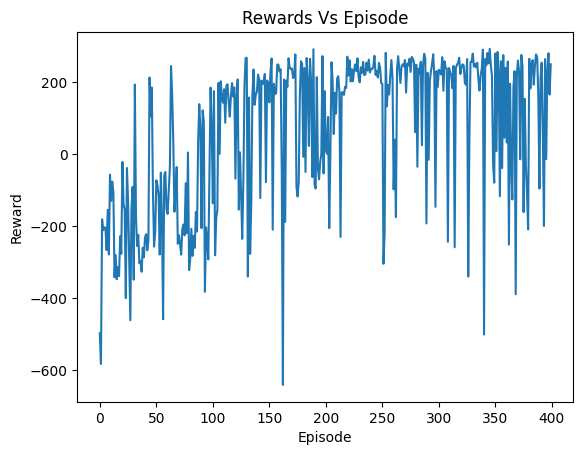

In [ ]:
#rewards vs episode
plt.plot(rewards_dqn)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards Vs Episode')
plt.show()

In [ ]:
env.close()

In [ ]:
#evaluation
env = gym.make("LunarLander-v3", render_mode='human')

state = env.reset()[0]
total_reward = 0
done = False

while not done:
  action = epsilon_greedy(state, 0)
  next_state, reward, done, _, _ = env.step(action)

  state = next_state
  total_reward += reward

  if step_num >= MAX_STEPS:
    break
  step_num += 1

print(f"Total reward for evaluation: {total_reward}")

env.close()

Total reward for evaluation: 275.07547528701184


**Did your agent learn to land consistently?**
  - Yes

**How many episodes did it take before you saw improvement?**
  - About 100

**What effect did replay buffer size, target update frequency, and learning rate have on stability?**
  - Increased replay buffer size would increase stability
    - More past experiences for network to train off of
  - Increased target update frequency decreased stability
    - Done through experimentation, best update frequency was once per step
  - Decreased learning rate increases training stability since higher learning rate causes overshoot in the model.

Compare results across different runs (does it sometimes fail to converge?).
  - The model eventually converges, but will sometimes take more episodes to do so.

***

**Comparison to MountainCar:**
  - LunarLander has more input values than MountainCar, so there is a much higher number of possible states that the model can be in. In addition, the agent has to react to a finer level in LunarLander than in MountainCar. For example, being slightly off in orientation should lead the model to react as such, something that isn't possible in tile coding without a very high number of tiles to represent possible states.
  - Neural networks are better at generalizing than tile coding, so it makes sense that they would be better at figuring out the optimal policy from a larger input space through exploration. While tile-coding requires the agent to visit a state at least once to develop a proper reaction to that state, neural networks are able to make a good approximation from the training data.